In [79]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

gene_expression = pd.read_csv("mappedListHugo.csv")
metadata = pd.read_csv("metadata_mappedListHugo.csv")
expression_data = gene_expression.iloc[:, 3:]
gene_var = expression_data.var(axis=1)
top_genes = expression_data.iloc[gene_var.nlargest(5000).index]
top_genes = top_genes.T
top_genes = top_genes.apply(pd.to_numeric, errors='coerce')

scaler = StandardScaler()
X_scaled = scaler.fit_transform(top_genes)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)
labels = gmm.predict(X_scaled)



In [75]:

# Try different numbers of clusters and compare BIC
for n in [2, 3, 4 ,5, 10, 20, 50, 100, 500]:
    gmm = GaussianMixture(n_components=n,covariance_type= 'diag', random_state=42)
    gmm.fit(X_scaled)
    bic = gmm.bic(X_scaled)
    print(f"BIC for GMM with {n} components: {bic}")


BIC for GMM with 2 components: 12077458.048977619
BIC for GMM with 3 components: 11582737.544936152
BIC for GMM with 4 components: 11288106.533246296
BIC for GMM with 5 components: 11128220.930916902
BIC for GMM with 10 components: 10734055.861545326
BIC for GMM with 20 components: 10520876.299455525
BIC for GMM with 50 components: 11017111.59923292
BIC for GMM with 100 components: 11633098.917084206
BIC for GMM with 500 components: 12800720.933552891


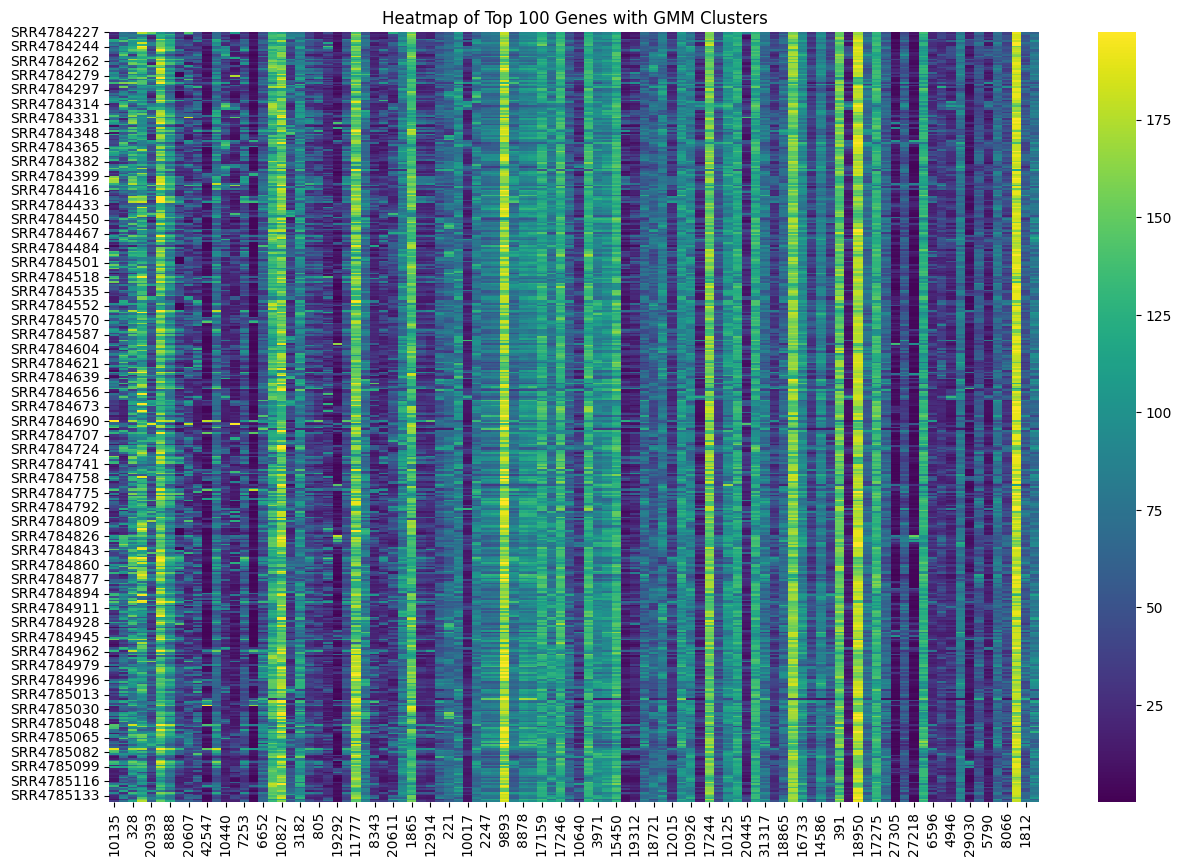

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the top 5000 genes with rows (samples) colored by cluster labels
plt.figure(figsize=(15, 10))  # Adjust the size to make the heatmap larger (width, height)

sns.heatmap(top_genes.iloc[:, :100], cmap='viridis', annot=False)  # Visualize the first 100 genes for clarity
plt.title("Heatmap of Top 100 Genes with GMM Clusters")
plt.show()


In [78]:
from scipy.stats import chi2_contingency

contingency_table = pd.crosstab(metadata['refinebio_disease'], labels)
# Perform chi-squared test
chi2, p, dof, expected = chi2_contingency(contingency_table)

print(f"Chi-squared test statistic: {chi2}, p-value: {p}")


Chi-squared test statistic: 0.0, p-value: 1.0


In [82]:
n = [2,3,5,10,50,100]

for i in n:
    gmm = GaussianMixture(n_components=i,covariance_type= 'diag', random_state=42)
    gmm.fit(X_scaled)
    contingency_table = pd.crosstab(metadata['refinebio_disease'], gmm.predict(X_scaled))
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"{i} Clusters Chi-squared test statistic: {chi2}, p-value: {p}")

2 Clusters Chi-squared test statistic: 68.84338005507597, p-value: 3.982164913512638e-14
3 Clusters Chi-squared test statistic: 73.79984005830671, p-value: 8.575392360968761e-13
5 Clusters Chi-squared test statistic: 86.50527038839664, p-value: 1.095922135706682e-11
10 Clusters Chi-squared test statistic: 136.6933537281086, p-value: 1.1969860908153836e-13
50 Clusters Chi-squared test statistic: 857.2448184138648, p-value: 1.953548588898849e-83
100 Clusters Chi-squared test statistic: 1685.7276948124972, p-value: 2.7426278781718395e-158


In [68]:

top_genes_filtered = top_genes.iloc[:, :len(labels)] 

if top_genes_filtered.shape[0] == len(labels):
    cluster_0 = top_genes_filtered[labels == 0].iloc[:, 3:]
    cluster_1 = top_genes_filtered[labels == 1].iloc[:, 3:]

    t_stat, p_value = ttest_ind(cluster_0.iloc[:, 0], cluster_1.iloc[:, 0])

    print(f"T-statistic: {t_stat}, P-value: {p_value}")
else:
    print("Filtered data length does not match GMM labels.")


T-statistic: -2.4593700229470894, P-value: 0.01540682272801067


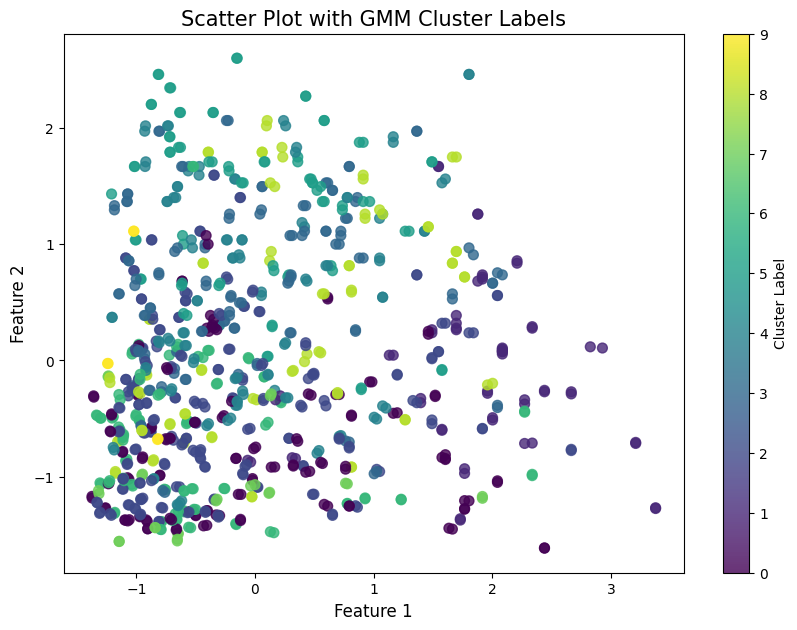

In [95]:
import matplotlib.pyplot as plt

# Assuming X_scaled is your scaled dataset and gmm is your trained Gaussian Mixture Model
# Predict cluster labels for the data
gmm = GaussianMixture(n_components=10,covariance_type = 'diag', random_state=42)
gmm.fit(X_scaled)
cluster_labels = gmm.predict(X_scaled)

# Scatter plot of the original data with cluster labels
plt.figure(figsize=(10, 7))

# Plot data points, colored by their cluster label
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.8)

# Adding labels and title
plt.title('Scatter Plot with GMM Cluster Labels', fontsize=15)
plt.xlabel('Feature 1', fontsize=12)
plt.ylabel('Feature 2', fontsize=12)

# Add a color bar to map the colors to cluster labels
plt.colorbar(label='Cluster Label')

plt.show()


Silhouette Score: 0.07534308806159054


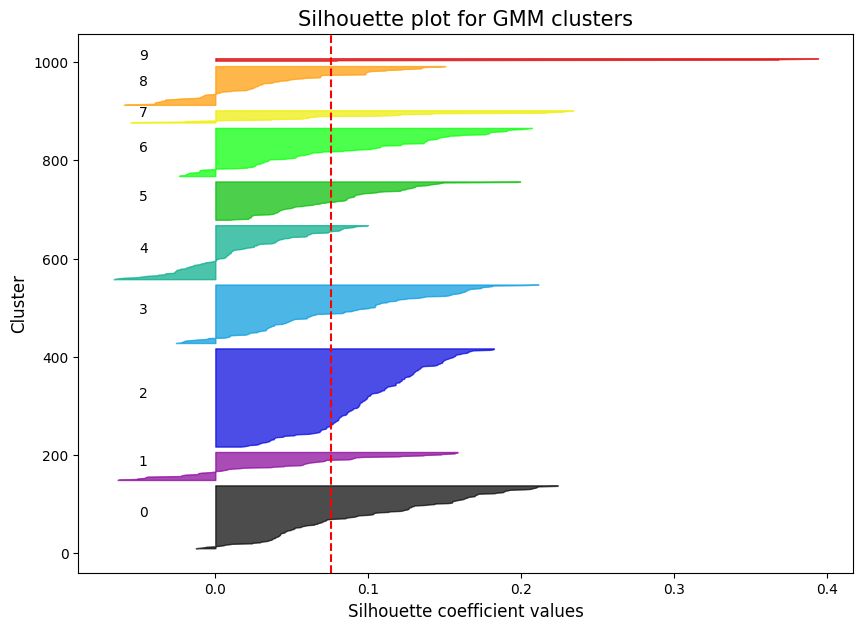

In [96]:
from sklearn.metrics import silhouette_score, silhouette_samples
import matplotlib.cm as cm

# Calculate the silhouette score
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f'Silhouette Score: {silhouette_avg}')

# Calculate the silhouette values for each sample
silhouette_values = silhouette_samples(X_scaled, cluster_labels)

# Plotting the silhouette scores
fig, ax = plt.subplots(figsize=(10, 7))

# The range of cluster labels
y_lower = 10
for i in range(10):  # Assuming n_components is the number of GMM components
    ith_cluster_silhouette_values = silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / 10)
    ax.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10  # Add some space between clusters

# Set titles and labels
ax.set_title("Silhouette plot for GMM clusters", fontsize=15)
ax.set_xlabel("Silhouette coefficient values", fontsize=12)
ax.set_ylabel("Cluster", fontsize=12)

# The vertical line for average silhouette score
ax.axvline(x=silhouette_avg, color="red", linestyle="--")

plt.show()


In [97]:
from sklearn.mixture import GaussianMixture

# Define covariance types to compare
covariance_types = ['full', 'tied', 'diag', 'spherical']
bic_scores = []

# Loop over each covariance type and fit a GMM
for cov_type in covariance_types:
    gmm = GaussianMixture(n_components=3, covariance_type=cov_type, random_state=42)
    gmm.fit(X_scaled)
    
    # Calculate the BIC
    bic = gmm.bic(X_scaled)
    bic_scores.append((cov_type, bic))
    print(f"BIC for GMM with {cov_type} covariance: {bic}")

# Sort BIC scores in ascending order for comparison
bic_scores.sort(key=lambda x: x[1])

# Display results
print("\nCovariance types sorted by BIC:")
for cov_type, bic in bic_scores:
    print(f"Covariance Type: {cov_type}, BIC: {bic}")


BIC for GMM with full covariance: 205525216.4847448
BIC for GMM with tied covariance: 42281873.01429468
BIC for GMM with diag covariance: 11582737.544936152
BIC for GMM with spherical covariance: 11845086.9614478

Covariance types sorted by BIC:
Covariance Type: diag, BIC: 11582737.544936152
Covariance Type: spherical, BIC: 11845086.9614478
Covariance Type: tied, BIC: 42281873.01429468
Covariance Type: full, BIC: 205525216.4847448


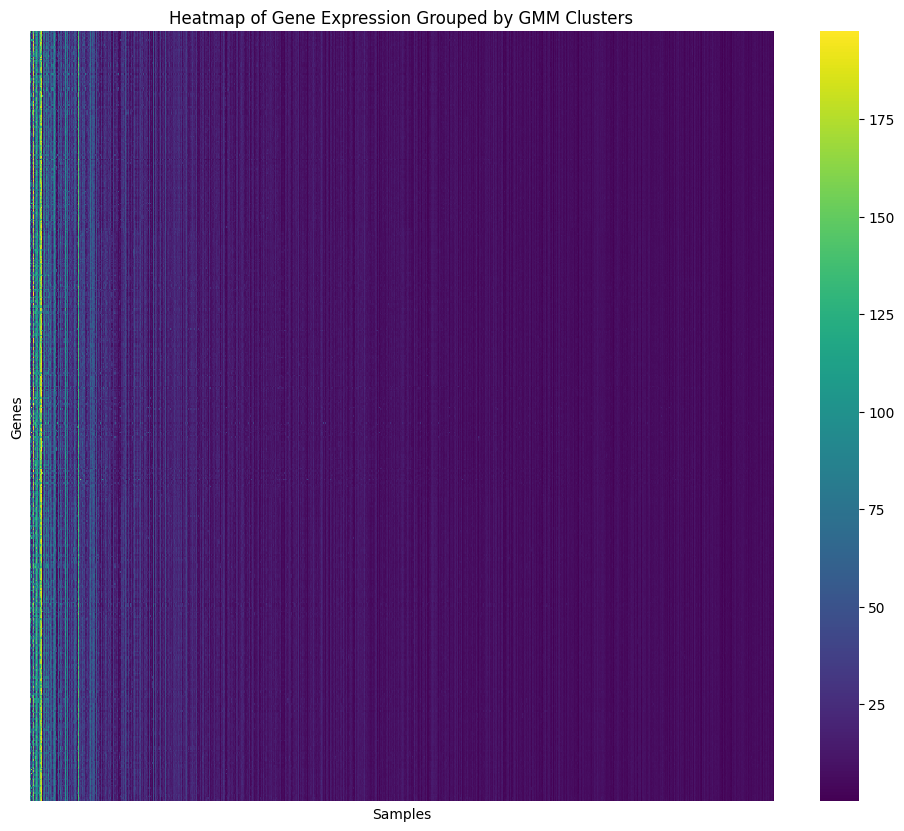

In [100]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the gene expression data and metadata
gene_expression = pd.read_csv("mappedListHugo.csv")
metadata = pd.read_csv("metadata_mappedListHugo.csv")

# Extract the expression data, exclude non-numeric columns
expression_data = gene_expression.iloc[:, 3:]

# Select top 5000 genes based on variance
gene_var = expression_data.var(axis=1)
top_genes = expression_data.iloc[gene_var.nlargest(5000).index]

# Transpose and handle non-numeric values
top_genes = top_genes.T
top_genes = top_genes.apply(pd.to_numeric, errors='coerce')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(top_genes)

# Fit Gaussian Mixture Model with 3 components
gmm = GaussianMixture(n_components=100,covariance_type='diag', random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)

# Add cluster labels to the data for heatmap visualization
top_genes['Cluster'] = labels

# Sort the data by cluster labels for a clearer heatmap
sorted_genes = top_genes.sort_values('Cluster')

# Drop the cluster column before plotting the heatmap
heatmap_data = sorted_genes.drop(columns=['Cluster'])

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="viridis", xticklabels=False, yticklabels=False)

# Add titles and labels
plt.title("Heatmap of Gene Expression Grouped by GMM Clusters")
plt.xlabel("Samples")
plt.ylabel("Genes")

# Show the heatmap
plt.show()


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import numpy as np

# Load the gene expression data and metadata
gene_expression = pd.read_csv("mappedListHugo.csv")
metadata = pd.read_csv("metadata_mappedListHugo.csv")

# Extract the expression data, exclude non-numeric columns
expression_data = gene_expression.iloc[:, 3:]

# Select top 100 genes based on variance
gene_var = expression_data.var(axis=1)
top_genes = expression_data.iloc[gene_var.nlargest(100).index]

# Transpose and handle non-numeric values
top_genes = top_genes.T
top_genes = top_genes.apply(pd.to_numeric, errors='coerce')

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(top_genes)

# Fit Gaussian Mixture Model with 3 components
gmm = GaussianMixture(n_components=3, random_state=42)
gmm.fit(X_scaled)

# Predict cluster labels
labels = gmm.predict(X_scaled)

# Add cluster labels to the data for heatmap visualization
top_genes['Cluster'] = labels

# Sort the data by cluster labels for a clearer heatmap
sorted_genes = top_genes.sort_values('Cluster')

# Drop the cluster column before plotting the heatmap
heatmap_data = sorted_genes.drop(columns=['Cluster'])

# Plotting the heatmap, limited to 100 genes
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_data, cmap="viridis", xticklabels=False, yticklabels=False)

# Add titles and labels
plt.title("Heatmap of Top 100 Genes Grouped by GMM Clusters")
plt.xlabel("Samples")
plt.ylabel("Genes")

# Show the heatmap
plt.show()
